In [2]:
!pip install pyRKHSstats
!pip install -U numpy scipy matplotlib scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 11.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 81.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6━━━━━━ 0/6 [numpy]
  Attempting uninstall: scipy━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/6 [cython]
    Found existing installation: scipy 1.15.3━━━━━━━━━━━━━━━━━ 1/6 [cython]
    Uninstalling scipy-1.15.3:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/6 [cython]
      Successfully uninstalled scipy-1.15.3━━━━━━━━━━━━━━━━━━━━━━━ 2/6 [scipy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [pyRKHSstats] [GPy]y]
  Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached a

In [1]:
import kernel
import numpy as np
import scipy
import matplotlib as plt
import sklearn
import johnson
import matplotlib.pyplot as plt
import time
import PyRKHSstats
from PyRKHSstats import mmd as mmd_module
from PyRKHSstats import kernel_wrapper
import warnings
import tensorflow as tf

warnings.filterwarnings("ignore")

seed = 1048596
rbf = kernel.GaussianKernel()

2025-05-30 20:55:56.493216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 20:55:56.495560: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 20:55:56.502119: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 20:55:56.517387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748638556.541875   23640 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748638556.54

# I. Goodness of fit of the Johnson's approximation

In [2]:
rng = np.random.default_rng(seed)

MMDs = []
n_MMD = 1_000
n = 1_000
m = 10_000

for k in range(n_MMD):
    X = rng.multivariate_normal(np.zeros(2), np.eye(2), n)
    Y = rng.multivariate_normal(np.zeros(2), np.eye(2), n)
    mmd = rbf.MMD_2_U(X, Y)
    MMDs.append(mmd)

MMDs = np.array(MMDs)

X = rng.multivariate_normal(np.zeros(2), np.eye(2), m)
Y = rng.multivariate_normal(np.zeros(2), np.eye(2), m)
moments = rbf.moments_MMD_2_U(X, Y)
distrib = johnson.fit_johnsonsu_by_moments(*moments)

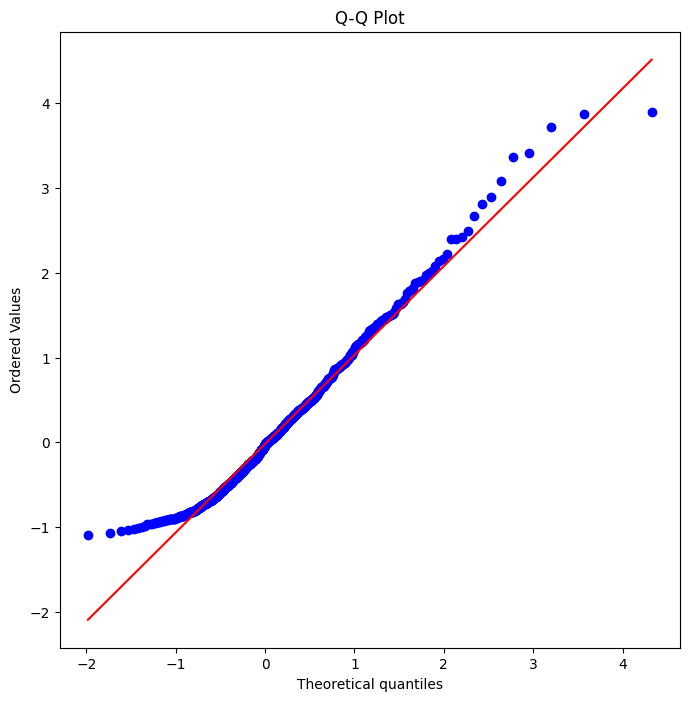

In [3]:
plt.figure(figsize=(8, 8))
scipy.stats.probplot(MMDs, dist=distrib, plot=plt)
plt.title('Q-Q Plot')
plt.show()

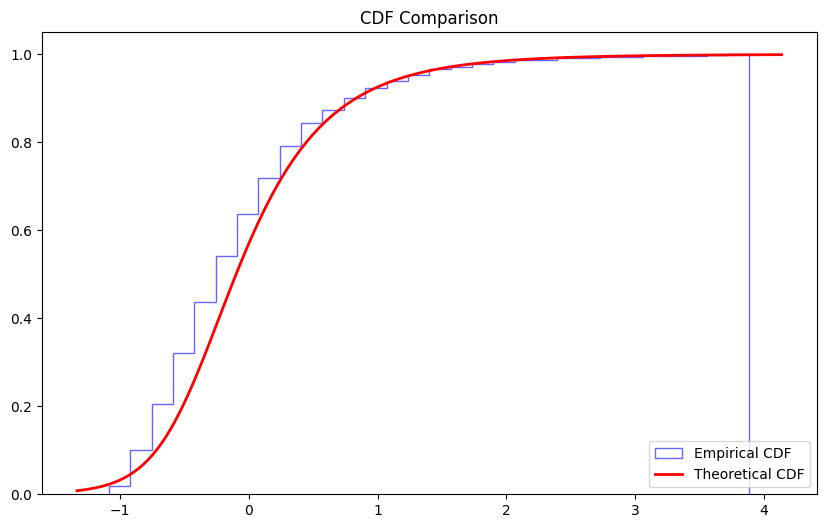

In [4]:
plt.figure(figsize=(10, 6))

# Empirical CDF
plt.hist(MMDs, bins=30, density=True, cumulative=True, 
         alpha=0.6, color='b', histtype='step', label='Empirical CDF')

# Theoretical CDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
plt.plot(x, distrib.cdf(x), 'r-', lw=2, label='Theoretical CDF')

plt.title('CDF Comparison')
plt.legend(loc='lower right')
plt.show()

In [5]:
ks_statistic, p_value = scipy.stats.kstest(MMDs, distrib.cdf)
print(p_value)

0.00020792834508669622


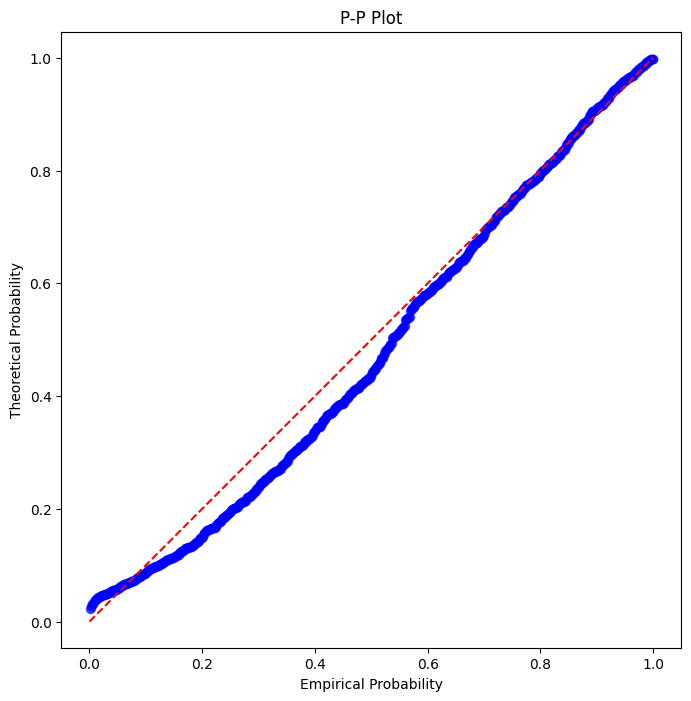

In [6]:
plt.figure(figsize=(8, 8))

# Calculate empirical and theoretical CDF values
sample_sorted = np.sort(MMDs)
ecdf = np.arange(1, len(MMDs)+1) / len(MMDs)
tcdf = distrib.cdf(sample_sorted)

# Plot
plt.plot(ecdf, tcdf, 'bo', alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # Reference line
plt.xlabel('Empirical Probability')
plt.ylabel('Theoretical Probability')
plt.title('P-P Plot')
plt.axis('equal')
plt.show()

# II. Synthetic data

In [7]:
def wilson_interval(k, n, confidence=0.95):
    p_hat = k / n
    z = scipy.stats.norm.ppf(1 - (1 - confidence)/2)
    center = (p_hat + z**2/(2*n)) / (1 + z**2/n)
    margin = z * np.sqrt((p_hat*(1 - p_hat)/n + z**2/(4*n**2)) / (1 + z**2/n))
    lower = np.maximum(0, center - margin)
    upper = np.minimum(1, center + margin)
    return center, lower, upper

In [8]:
def plot(X, xlabel, results, ylabel, test_names, title, xlog=False, ylog=False, ic=False):

    plt.figure(figsize=(15, 5))
    colors = plt.cm.tab10.colors
    markers = ["o", "x", "v", "^", "h"]

    if ic:
        ics = np.zeros((results.shape[0], results.shape[1], 3))  # Center, lower, upper
        for i in range(results.shape[0]):
            for k in range(results.shape[2]):
                rejections = results[i, :, k].sum()
                center, lower, upper = wilson_interval(rejections, results.shape[1])
                ics[i, k] = [center, lower, upper]
        
        for k in range(results.shape[2]):
            center = ics[:, k, 0]
            lower = ics[:, k, 1]
            upper = ics[:, k, 2]
            
            plt.plot(X, center, color=colors[k], label=test_names[k], marker=markers[k], linestyle="-")
            plt.fill_between(X, lower, upper, color=colors[k], alpha=0.2)
    
    else:
        avg = results.mean(axis=1)
        for k in range(results.shape[1]):
            plt.plot(X, avg[:, k], 
                    color=colors[k],
                    marker='o',
                    linestyle='-',
                    label=test_names[k])

    plt.xlabel(xlabel)
    if xlog:
        plt.xscale('log')
    plt.ylabel(ylabel)
    if ylog:
        plt.yscale('log')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [9]:
P = 200
alpha = 0.05
rbf = kernel.GaussianKernel()
wrapped_rbf = kernel_wrapper.KernelWrapper(rbf)

## A) One-dimensional gaussians

In [10]:
rng = np.random.default_rng(seed)
np.random.seed(seed)

sigma_min, sigma_max = 0.505, 0.66
n_sigma = 10
sigmas = np.linspace(sigma_min, sigma_max, n_sigma)
n_rep = 5
n = 500


tests = [lambda X, Y, rng: rbf.test_MMD_2_U_M(X, Y, alpha),
lambda X, Y, rng: int(mmd_module.perform_permutation_mmd(X, Y, wrapped_rbf, alpha, P)['Reject H0 (H0 : P_X = P_Y)']),
lambda X, Y, rng: int(mmd_module.perform_gram_matrix_spectrum_mmd(X, Y, wrapped_rbf, alpha, P)['Reject H0 (H0 : P_X = P_Y)']),
lambda X, Y, rng: rbf.test_mmd_nystrom_uniform(X, int(np.sqrt(X.shape[0]) / 2), Y, int(np.sqrt(Y.shape[0]) / 2), alpha, P, rng),
lambda X, Y, rng: int(scipy.stats.ks_2samp(X, Y).pvalue[0] <= alpha),
]
test_names = ["MMD²-Moments", "MMD²-Permutation", "MMD²-Gram", "MMD-Nyström", "KS"]

results = np.zeros((n_sigma, n_rep, len(tests)))

for i, sigma in enumerate(sigmas):
    for j in range(n_rep):
        X = rng.normal(0, 0.5, n).reshape(-1, 1)
        Y = rng.normal(0, sigma, n).reshape(-1, 1)
        rbf.fit_bandwidth(X, Y, 500)
        for k in range(len(tests)):
            results[i, j, k] = tests[k](X, Y, rng)

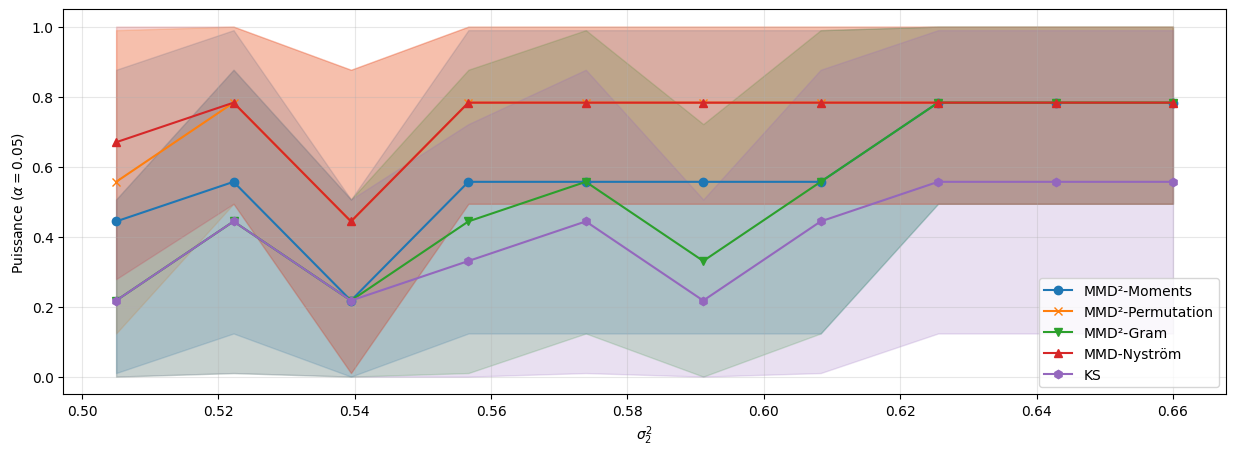

In [11]:
plot(sigmas, "$\sigma_2^2$", results, r"Puissance ($\alpha=0.05$)", test_names, "", ic=True)


In [12]:
rng = np.random.default_rng(seed)
np.random.seed(seed)

sigma = 0.6
n_rep = 2
n_sizes = 10
sample_sizes = np.exp(np.linspace(np.log(100), np.log(2000), n_sizes)).astype(int)
times = np.zeros((n_sizes, n_rep, len(tests)))

for i, n in enumerate(sample_sizes):
    for j in range(n_rep):
        X = rng.normal(0, 0.5, n).reshape(-1, 1)
        Y = rng.normal(0, sigma, n).reshape(-1, 1)
        for k in range(len(tests)):
            t = time.perf_counter()
            tests[k](X, Y, rng)
            times[i, j, k] = time.perf_counter() - t

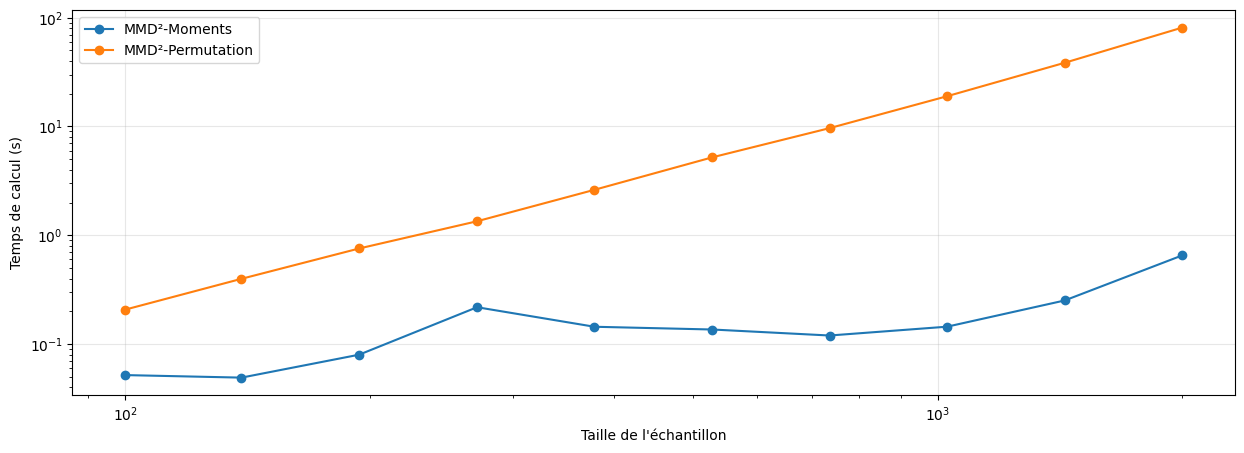

In [13]:
plot(sample_sizes, "Taille de l'échantillon", times, "Temps de calcul (s)", test_names, "", xlog=True, ylog=True)

In [14]:
rng = np.random.default_rng(seed)

n = 1000
n_rep = 500
rejections = 0
for k in range(n_rep):
    X = rng.normal(0, 1, n).reshape(-1, 1)
    Y = rng.normal(0, 1, n).reshape(-1, 1)
    rejections += rbf.test_MMD_2_U_M(X, Y, alpha)

print(wilson_interval(rejections, n_rep))

(np.float64(0.09709548222739021), np.float64(0.07132799057556974), np.float64(0.12286297387921069))


## B) Multidimensional gaussians

In [15]:
rng = np.random.default_rng(seed)

sigma_min, sigma_max = 0.505, 0.66
sigmas = np.linspace(sigma_min, sigma_max, n_sigma)
n_sigma = 10
n_rep = 100
n = 500


tests = [lambda X, Y, rng: rbf.test_MMD_2_U_M(X, Y, alpha),
lambda X, Y, rng: rbf.test_mmd_nystrom_uniform(X, int(np.sqrt(X.shape[0]) / 2), Y, int(np.sqrt(Y.shape[0]) / 2), alpha, P, rng)]
test_names = ["MMD²-Moments", 
"MMD-Nyström"]

results = np.zeros((n_sigma, n_rep, len(tests)))

for i, sigma in enumerate(sigmas):
    for j in range(n_rep):
        X = rng.multivariate_normal(np.zeros(3), np.eye(3) + 0.5 * (1 - np.eye(3)), n)
        Y = rng.multivariate_normal(np.zeros(3), np.eye(3) + sigma * (1 - np.eye(3)), n)
        rbf.fit_bandwidth(X, Y, 500)
        for k in range(len(tests)):
            results[i, j, k] = tests[k](X, Y, rng)

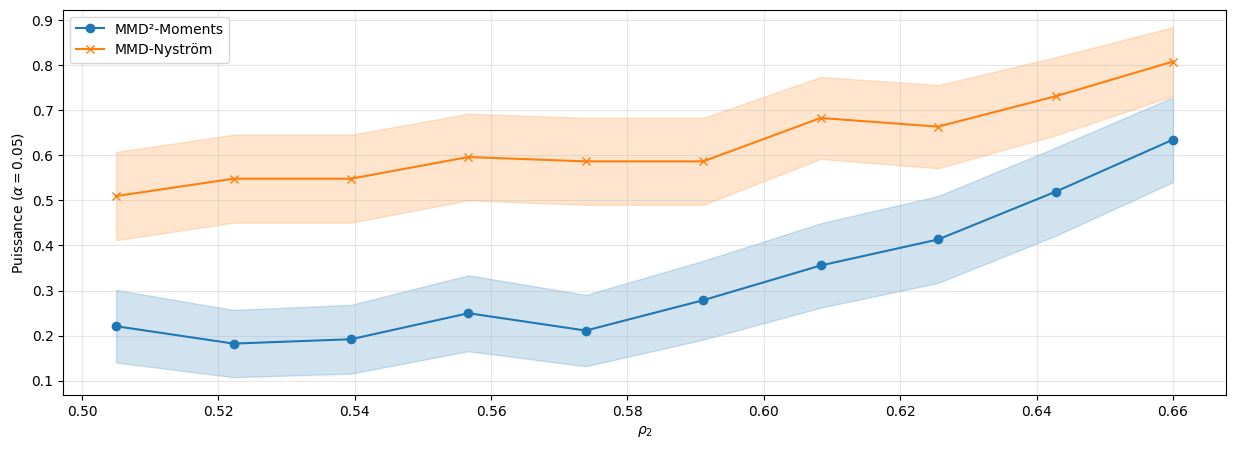

In [16]:
plot(sigmas, r"$\rho_2$", results, r"Puissance ($\alpha=0.05$)", test_names, "", ic=True)

In [17]:
rng = np.random.default_rng(seed)

n_rep = 10
n = 500
n_dims = 20
dims = np.linspace(10, 2_000, n_dims).astype(int)

tests = [lambda X, Y, rng: rbf.test_mmd_nystrom_uniform(X, int(np.sqrt(X.shape[0]) / 2), Y, int(np.sqrt(Y.shape[0]) / 2), alpha, P, rng)]
test_names = ["MMD-Nyström"]

results = np.zeros((n_dims, n_rep, len(tests)))

for i, dim in enumerate(dims):
    for j in range(n_rep):
        X = rng.multivariate_normal(np.zeros(dim), 0.5 * np.eye(dim), n)
        Y = rng.multivariate_normal(np.ones(dim) / np.sqrt(dim), 0.5 * np.eye(dim), n)
        rbf.fit_bandwidth(X, Y, 500)
        for k in range(len(tests)):
            results[i, j, k] = tests[k](X, Y, rng)

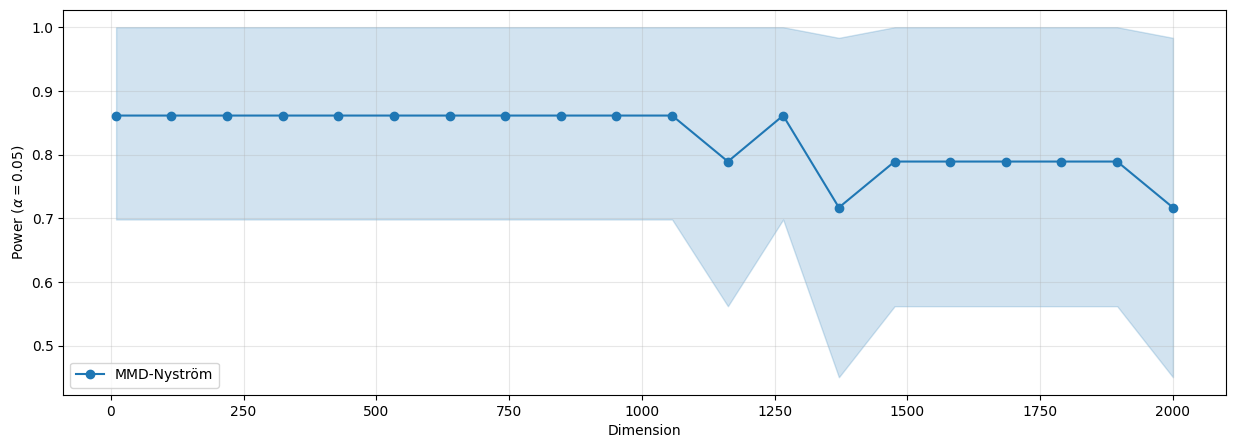

In [18]:
plot(dims, "Dimension", results, r"Power ($\alpha=0.05$)", test_names, "", ic=True)

# II. Higgs Dataset

In [19]:
import tensorflow as tf

gz = tf.keras.utils.get_file(
    'HIGGS.csv.gz', 
    'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz'
)

2816407858/2816407858 ━━━━━━━━━━━━━━━━━━━━ 203s 0us/step


In [21]:
FEATURES = 28
record_defaults = [tf.constant(0.0, dtype=tf.float32)] * (FEATURES + 1)

ds = tf.data.experimental.CsvDataset(
    filenames=gz,
    record_defaults=record_defaults,
    compression_type="GZIP",
    header=False  # No header row
)
def pack_features(*row):
    label = row[0]
    features = tf.stack(row[1:], axis=0)
    return features, label

packed_ds = ds.map(pack_features)

bg_ds = np.array(list(packed_ds.filter(lambda features, label: label == 0).map(lambda features, label: features[:14]).take(200_000)))
sg_ds = np.array(list(packed_ds.filter(lambda features, label: label == 1).map(lambda features, label: features[:14]).take(200_000)))

Cause: could not parse the source code of <function <lambda> at 0x7fd400093f60>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda features, label: features[:14]

Match 1:
lambda features, label: label == 0

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd400093f60>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda features, label: features[:14]

Match 1:
lambda features, label: label == 0

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 

2025-05-30 21:29:56.351290: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-30 21:30:28.692898: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cause: could not parse the source code of <function <lambda> at 0x7fd400093560>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda features, label: features[:14]

Match 1:
lambda features, label: label == 1

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd400093560>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda features, label: features[:14]

Match 1:
lambda features, label: label == 1

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 

2025-05-30 21:30:53.066861: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
def generate_samples(bg_data, sg_data, n, alpha_mix, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    n_bg = int((1 - alpha_mix) * n)
    n_sg = n - n_bg
    

    bg_samples = rng.choice(bg_data, size=n_bg + n, replace=False)
    P_sample, bg_sample = bg_samples[:n], bg_samples[n:]
    sg_sample = rng.choice(sg_data, size=n_sg, replace=False)
    
    Q_sample = np.vstack([bg_sample, sg_sample])
    
    rng.shuffle(P_sample, axis=0)
    rng.shuffle(Q_sample, axis=0)
    return P_sample, Q_sample

In [23]:
rng = np.random.default_rng(seed)

rbf = kernel.GaussianKernel()

alpha = 0.95
P = 200
n_rep = 20
n_min, n_max = 1000, 80_000
n_samples = 8
sample_sizes = np.linspace(n_min, n_max, n_samples).astype(int)
alpha_mix = 0.2

tests = [lambda X, Y, rng: rbf.test_mmd_nystrom_uniform(X, int(np.sqrt(X.shape[0]) / 2), Y, int(np.sqrt(Y.shape[0]) / 2), alpha, P, rng)]
test_names = ["MMD-Nyström"]

results = np.zeros((n_samples, n_rep, len(tests)))

for i, n in enumerate(sample_sizes):
    for j in range(n_rep):
        X, Y = generate_samples(bg_ds, sg_ds, n, alpha_mix)
        rbf.fit_bandwidth(X, Y, min(n, 2000))
        for k in range(len(tests)):
            results[i, j, k] = tests[k](X, Y, rng)

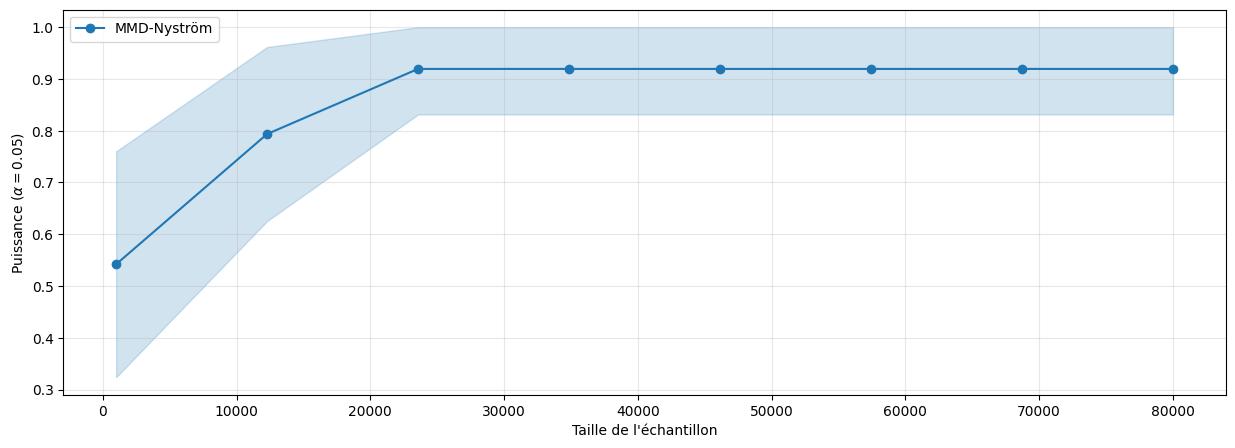

In [24]:
plot(sample_sizes, "Taille de l'échantillon", results, r"Puissance ($\alpha=0.05$)", test_names, "", ic=True)

In [25]:
rng = np.random.default_rng(seed)

n_rep = 100
n = 16_000
l_min, l_max = 10, 1000
n_features = 10
features_lengths = np.exp(np.linspace(np.log(l_min), np.log(l_max), n_features)).astype(int)
alpha_mix = 0.2

tests = [lambda X, Y, rng: rbf.test_mmd_nystrom_uniform(X, int(np.sqrt(X.shape[0]) / 2), Y, int(np.sqrt(Y.shape[0]) / 2), alpha, P, rng)]
test_names = ["MMD-Nyström"]

results = np.zeros((n_features, n_rep, len(tests)))

X, Y = generate_samples(bg_ds, sg_ds, n, alpha_mix)
rbf.fit_bandwidth(X, Y, 2000)

for i, n in enumerate(features_lengths):
    for j in range(n_rep):
        for k in range(len(tests)):
            results[i, j, k] = rbf.test_mmd_nystrom_uniform(X, int(i / 2), Y, int(i / 2), alpha, P, rng)

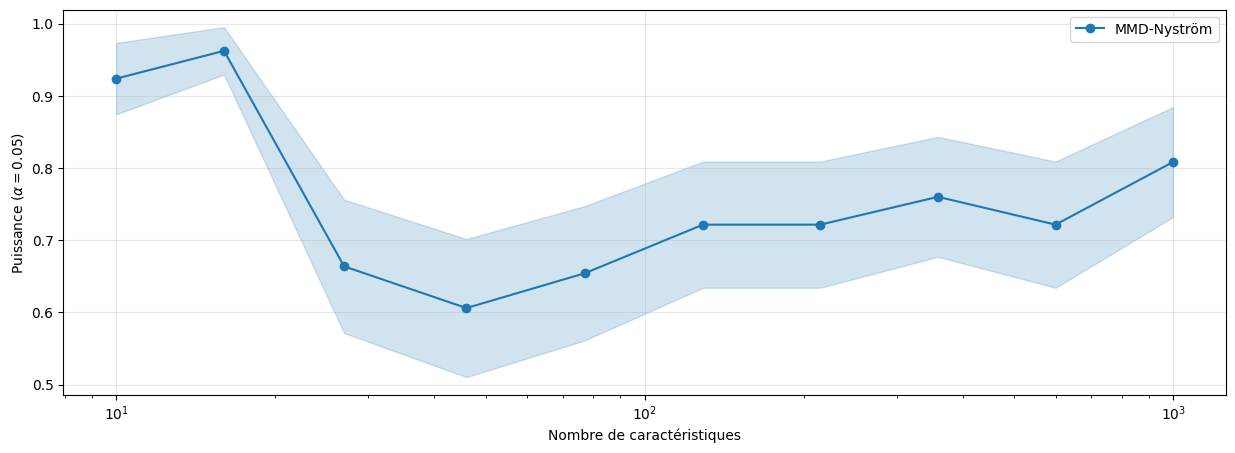

In [26]:
plot(features_lengths, "Nombre de caractéristiques", results, r"Puissance ($\alpha=0.05$)", test_names, "", xlog=True, ic=True)